# Arecibo Planetary Radar Doppler/Delay Image Processing

References:
* https://iopscience.iop.org/article/10.3847/PSJ/ac4f43/pdf -- *Arecibo Radar Maps of Venus from 1988 to 2020* (overview paper)
* https://pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/document/venus_radar.pdf -- Level 1 doppler/dely data description
* https://pds-geosciences.wustl.edu/venus/urn-nasa-pds-venus_radar_level2/document/venus_radar_maps_user_guide.pdf -- Level 2 multi-look data description
* https://pubs.usgs.gov/of/1993/0516/report.pdf -- Venus Geologic Mappers' Handbook
* https://repository.si.edu/bitstream/handle/10088/3303/200737.pdf -- *Focused 70-cm wavelength radar mapping of the moon* Details on the doppler/delay transformations
* https://echo.jpl.nasa.gov/asteroids/harmon.2002.long.code.pdf -- Details on the long-code doppler-delay method

Tools/Libraries:
* https://ssd.jpl.nasa.gov/horizons/app.html#/ -- JPL Horizons web app
* https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html -- JPL Horizons Python API
* https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf -- Latest ephemerides description
* https://astropedia.astrogeology.usgs.gov/download/Docs/WGCCRE/WGCCRE2009reprint.pdf --  Report of the IAU Working Group on Cartographic Coordinates and Rotational Elements: 2009
* https://escholarship.org/content/qt2dn1012s/qt2dn1012s.pdf?t=pv3anr -- The mean rotation rate of Venus from 29 years of Earth-based radar observations (also describes doppler/delay transformation)

Maps:
* http://134.158.75.177/viewer/Apps/PlanetaryCesiumViewer/index.html?view=0%2C0%2C35255004%2C360%2C-90%2C0 -- with Venus lat/lon, etc.
* https://www.google.com/maps/space/venus/
* https://en.wikipedia.org/wiki/Mapping_of_Venus
* https://solarsystem.nasa.gov/resources/2342/venus-surface-3d-model/

In [32]:
from matplotlib import pyplot as pl
import numpy as np
import os
import pickle

## Apparent Rotation Angle (Doppler Angle) Functions

In [33]:
# Function: Poliastro-based doppler angle calculation
from astropy import units as au
from astropy import coordinates as ac
from astropy import constants as ak
from astropy import time as at
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation

# NOTE: You MUST use poliastro >=0.18 to avoid a bug in VenusFixed coordinates! (see https://github.com/poliastro/poliastro/issues/1599)

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

def apparentRotationAngle_poliastro(obstime):
    # Observer point (Arecibo) at observation time in ICRS frame
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    # Venus North Pole
    v = SpheroidLocation(0.0 * au.deg, 90.0 * au.deg, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vNP_fixed = VenusFixed(obstime=obstime,
                           x=x, y=y, z=z,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)

    vBC_o_icrs = vBC_fixed.transform_to(o_icrs)
    vNP_o_icrs = vNP_fixed.transform_to(o_icrs)

    # North Pole axis (in Arecibo frame)
    axis_NP = vNP_o_icrs.cartesian.without_differentials() - vBC_o_icrs.cartesian.without_differentials()
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis (in Arecibo frame)
    axis_BC = vBC_o_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    axis_BC /= axis_BC.norm()
    axis_AR = axis_BC.cross(vBC_o_icrs.velocity - o_icrs.velocity)
    axis_AR /= axis_AR.norm()

    # Project the North Pole axis onto the plane of the sky
    sky_NP = axis_BC.cross(axis_NP.cross(axis_BC))
    sky_NP /= sky_NP.norm()

    # Project the Apparent Rotation axis onto the plane of the sky
    sky_AR = axis_BC.cross(axis_AR.cross(axis_BC))
    sky_AR /= sky_AR.norm()

    # Calculate the angle difference between the two sky-projected axes, bounded from -90 to 90 degrees.
    sky_delta_angle = np.arccos(sky_NP.dot(sky_AR) / (sky_NP.norm() * sky_AR.norm()))
    if sky_delta_angle > 90 * au.deg: sky_delta_angle -= 180 * au.deg
    if sky_delta_angle < -90 * au.deg: sky_delta_angle += 180 * au.deg
    return sky_delta_angle

def orthogonalVelocity_poliastro(obstime):
    # Observer point (Arecibo) at observation time in ICRS frame
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')
    VenusICRS(obstime=obstime) # WORKAROUND
    vBC_o_icrs = vBC_fixed.transform_to(o_icrs)

    dpos = vBC_o_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    dvel = vBC_o_icrs.velocity - o_icrs.velocity

    dpos_m = dpos.xyz.to(au.m).value
    range_m = np.sqrt(np.sum(dpos_m**2))
    dvel_mps = dvel.d_xyz.to(au.m / au.s).value

    # "Radial" and "Orthogonal" velocity
    range_rate_mps = np.dot(dvel_mps, dpos_m / range_m)
    ortho_mps = np.sqrt(sum(dvel_mps**2) - range_rate_mps**2)
    #print(f'{range_m=}')
    #print(f'{range_rate_mps=}')
    #print(f'{ortho_mps=}')
    return ortho_mps

In [34]:
# Function: JPL Horizons-based doppler angle calculation
from astropy import coordinates as ac
from astroquery.jplhorizons import Horizons

def apparentRotationAngle_horizons(obstime):
    # Venus points in Arecibo (-1 @ 399) frame:
    # Venus Body Center
    vBC = Horizons(id='299',  location='-1 @ 399', epochs=obstime.tdb.jd).vectors()
    # Venus North Pole
    vNP = Horizons(id='g: 0, 90, 0 @ 299',  location='-1 @ 399', epochs=obstime.tdb.jd).vectors()

    vBC_pos = ac.CartesianRepresentation(
        x=vBC['x'][0] * vBC['x'].unit,
        y=vBC['y'][0] * vBC['y'].unit,
        z=vBC['z'][0] * vBC['z'].unit)
    vBC_vel = ac.CartesianRepresentation(
        x=vBC['vx'][0] * vBC['vx'].unit,
        y=vBC['vy'][0] * vBC['vy'].unit,
        z=vBC['vz'][0] * vBC['vz'].unit)

    vNP_pos = ac.CartesianRepresentation(
        x=vNP['x'][0] * vNP['x'].unit,
        y=vNP['y'][0] * vNP['y'].unit,
        z=vNP['z'][0] * vNP['z'].unit)
    vNP_vel = ac.CartesianRepresentation(
        x=vNP['vx'][0] * vNP['vx'].unit,
        y=vNP['vy'][0] * vNP['vy'].unit,
        z=vNP['vz'][0] * vNP['vz'].unit)

    # North Pole axis
    axis_NP = vNP_pos - vBC_pos
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis
    axis_BC = vBC_pos
    axis_BC /= axis_BC.norm()
    axis_AR = axis_BC.cross(vBC_vel)
    axis_AR /= axis_AR.norm()

    # Project the North Pole axis onto the plane of the sky
    sky_NP = axis_BC.cross(axis_NP.cross(axis_BC))
    sky_NP /= sky_NP.norm()

    # Project the Apparent Rotation axis onto the plane of the sky
    sky_AR = axis_BC.cross(axis_AR.cross(axis_BC))
    sky_AR /= sky_AR.norm()

    # Calculate the angle difference the two sky-projected axes
    sky_delta_angle = np.arccos(sky_NP.dot(sky_AR) / (sky_NP.norm() * sky_AR.norm()))
    if sky_delta_angle > 90 * au.deg: sky_delta_angle -= 180 * au.deg
    if sky_delta_angle < -90 * au.deg: sky_delta_angle += 180 * au.deg
    return sky_delta_angle

## Interactive script magic

In [35]:
_interactive = True  # Skip the next cell if you want to run in interactive (cell-by-cell) mode!

In [36]:
_interactive = False  # Automatically override _interactive to false if this notebook is run in batch mode!

## Main doppler/delay processing pipeline

In [37]:
ROOT_PREFIX = "data_venus/arecibo_radar/pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/"
DATA_PREFIX = ROOT_PREFIX + "data/"

In [38]:
if _interactive: ## Select filename
    # 1988:
    #filename = "venus_ocp_19880604_163910.img"  # First S (ever!)
    #filename = "venus_ocp_19880620_144220.img"
    #filename = "venus_ocp_19880618_150330.img"
    #filename = "venus_ocp_19880617_151830.img"

    # 2001:
    #filename = "venus_ocp_20010331_160048.img"
    #filename = "venus_ocp_20010331_184848.lbl"

    # 2012: used GBT, maybe avoid for now due to more complex antenna configuration

    # 2015:
    #filename = "venus_ocp_20150810_162629.img"  # First S
    #filename = "venus_ocp_20150810_163623.img"  # Next S
    #filename = "venus_ocp_20150816_171104.img"  # Last S
    #filename = "venus_ocp_20150812_155242.img"  # First N
    #filename = "venus_scp_20150815_172030.img"  # Last N
    filename = "venus_ocp_20150812_155242.img" # Bruce parameter comparison
    #filename = "venus_ocp_20150815_170058.img" # Bruce parameter comparison

    # 2017:

    # 2020:
    #filename = "venus_scp_20200530_175421.img"
    #filename = "venus_ocp_20200530_175421.img"
    #filename = "venus_ocp_20200530_174429.img"
    #filename = "venus_ocp_20200530_173437.img"
    #filename = "venus_ocp_20200530_172445.img"

    # Vertical roll experiments
    #filename = 'venus_ocp_20010331_163648.img'  # Actually needs to be rolled *down* by a small amount
    #filename = 'venus_ocp_20120527_180159.img'  # Needs to be rolled up significantly
    #filename = 'venus_ocp_19880605_175820.img'  # Weak signal?
    #filename = 'venus_scp_19880604_163910.img'   # weak
    #filename = 'venus_scp_20200524_182906.img' #  weakish

    # Fit experiments
    #filename = 'venus_ocp_19880604_163910.img'


In [39]:
# Function: Parse the .lbl metadata file
def parseLbl(filename):
    lbl_filepath = DATA_PREFIX + filename[:25] + ".lbl"
    l = {}
    for line in open(lbl_filepath).readlines():
        if 'START_TIME' in line:
            l['START_TIME'] = line.split('=')[-1].strip()
        if 'STOP_TIME' in line:
            l['STOP_TIME'] = line.split('=')[-1].strip()
        if 'GEO:BAUD' in line:
            l['GEO_BAUD'] = float(line.split(' ')[-2])
        if 'GEO:CENTROID_LOCATION' in line:
            l['GEO_CENTROID_LOCATION'] = int(line.split('=')[1].strip())
        if 'GEO:DELAY_OFFSET' in line:
            l['GEO_DELAY_OFFSET'] = int(line.split('=')[1].strip())
        if 'GEO:POINTING' in line:
            l['GEO_POINTING'] = line.split('"')[-2]
        if 'GEO:MODE' in line:
            l['GEO_MODE'] = line.split('"')[-2]
    return l


if _interactive: 
    lbl_dict = parseLbl(filename)
    print(f'{lbl_dict=}')

In [40]:
# Function: Load/fetch Horizons ephemeris data
from astropy import time as at
from astroquery.jplhorizons import Horizons

def loadOrFetchHorizonsData(filename):
    cache_filepath = DATA_PREFIX + filename[:25] + '_horizons.pkl'
    if os.path.exists(cache_filepath):
      return pickle.load(open(cache_filepath, 'rb'))
    # Cache miss: query JPL Horizons
    lbl_dict = parseLbl(f)
    start_astrotime = at.Time(lbl_dict['START_TIME'])
    stop_astrotime = at.Time(lbl_dict['STOP_TIME'])
    obj = Horizons(id='299',  # Venus
                   location='-1@399',  # Arecibo on Earth
                   epochs=[start_astrotime.jd, stop_astrotime.jd])
    hdata = {
          'start_astrotime': start_astrotime,
          'stop_astrotime': stop_astrotime,
          'ephemerides': obj.ephemerides(),
          'vectors': obj.vectors(),
        }
    pickle.dump(hdata, open(cache_filepath, 'wb'))
    return hdata


if 0: # Batch cache: Lookup and cache ALL the JPL Horizons ephemerides data.
    for f in os.listdir(DATA_PREFIX):
        if not f.endswith('.img'): continue
        loadOrFetchHorizonsData(f)


if _interactive: # Load sub-radar point (SRP) data
    hdata = loadOrFetchHorizonsData(filename)
    start_astrotime = hdata['start_astrotime']
    end_astrotime = hdata['start_astrotime']
    eph = hdata['ephemerides']
    srp_lon_deg = eph['PDObsLon'][0]
    srp_lat_deg = eph['PDObsLat'][0]
    if 1:  # debug
        print(f"{start_astrotime=}")
        print(f"{srp_lon_deg=}")
        print(f"{srp_lat_deg=}")
        print(f"{eph['NPole_ang'][0]=}")
    if 1:  # debug
        sky_delta_angle_poliastro = apparentRotationAngle_poliastro(start_astrotime)
        print(f'{sky_delta_angle_poliastro.to(au.deg).value=}')
        #sky_delta_angle_horizons = apparentRotationAngle_horizons(start_astrotime)
        #print(f'{sky_delta_angle_horizons.to(au.deg).value=}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


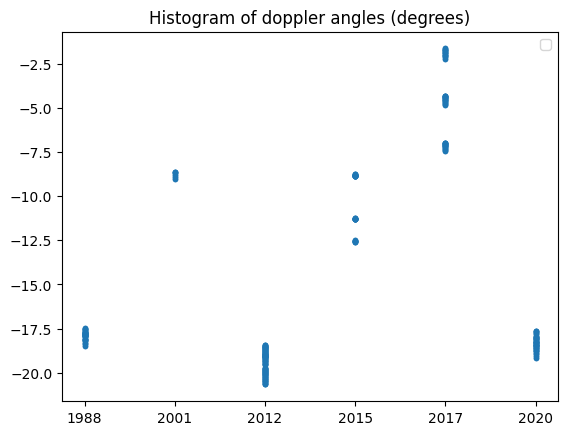

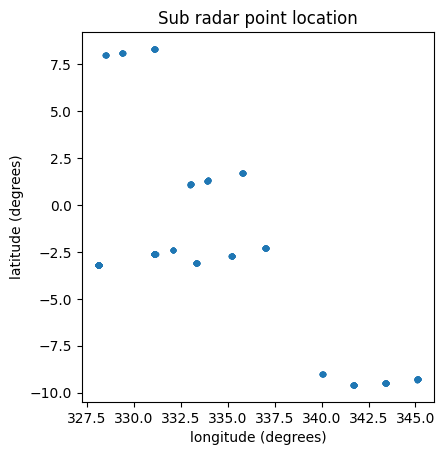

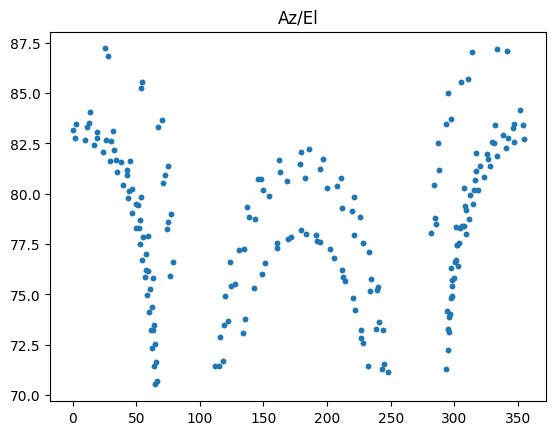

In [69]:
if 0: # debug: Compare ephemeris data
    YEAR = []
    NP_ANG_DEG = []
    NP_DIS_ARCSEC = []
    SRP_LON_DEG = []
    SRP_LAT_DEG = []
    DOP_ANG_DEG = []
    AZ_DEG = []
    EL_DEG = []
    for f in os.listdir(DATA_PREFIX):
        #if not '1988' in f: continue
        #if not '2015' in f: continue
        #if not '2017' in f: continue
        #if not '2020' in f: continue
        if not f.endswith('horizons.pkl'): continue
        lbl_dict = parseLbl(f)
        if lbl_dict['GEO_POINTING'] != "N": continue
        YEAR.append(lbl_dict['START_TIME'][:4])
        hdata = loadOrFetchHorizonsData(f)
        eph = hdata['ephemerides']
        NP_ANG_DEG.append(eph['NPole_ang'][0])
        NP_DIS_ARCSEC.append(eph['NPole_dist'][0])
        SRP_LON_DEG.append(eph['PDObsLon'][0])
        SRP_LAT_DEG.append(eph['PDObsLat'][0])
        AZ_DEG.append(eph['AZ'][0])
        EL_DEG.append(eph['EL'][0])
        if 1: # debug: Compare apparent rotation angles
            sky_delta_angle_poliastro = apparentRotationAngle_poliastro(hdata['start_astrotime'])
            #sky_delta_angle_horizons = apparentRotationAngle_horizons(hdata['start_astrotime'])
            #print(f'{sky_delta_angle_poliastro.to(au.deg)=}')
            #print(f'{sky_delta_angle_horizons.to(au.deg)=}')
            DOP_ANG_DEG.append(sky_delta_angle_poliastro.to(au.deg).value)
            #DOP_ANG_DEG.append(sky_delta_angle_horizons.to(au.deg).value)
        #print(SRP['start_astrotime'], eph['PDObsLon'][0], eph['PDObsLat'][0])
    print(len(SRP_LON_DEG))
    print(np.mean(SRP_LON_DEG))
    print(np.mean(SRP_LAT_DEG))

if 1: # debug
    #pl.plot(NP_DIS_ARCSEC)
    #pl.plot(NP_ANG_DEG)
    #pl.plot(DOP_ANG_DEG)
    #NP_ANG = np.array(NP_ANG)
    #pl.plot(np.where(NP_ANG > 180, NP_ANG - 360, NP_ANG))
    #pl.plot(SRP_LAT)

    # Sanity check: Campbell says that doppler angles should be ~10 degrees!
    # ??? -- these are up to 20 degrees!
    pl.figure()
    #pl.hist(DOP_ANG_DEG)
    #pl.title('Histogram of doppler angles (degrees)')
    pl.plot(YEAR, DOP_ANG_DEG, '.')
    pl.title('Doppler angles by year')

    # Sanity check: sub radar points should be within ~10 degrees of the Venusian equator
    pl.figure()
    pl.plot(SRP_LON_DEG, SRP_LAT_DEG, ".")
    pl.axis('scaled')
    pl.title('Sub radar point location')
    pl.xlabel('longitude (degrees)') 
    pl.ylabel('latitude (degrees)') 

    # Sanity check: elevation should be close to the zenith for Arecibo!
    pl.figure()
    pl.plot(AZ_DEG, EL_DEG, '.')
    pl.title("Az/El")

In [42]:
if _interactive:  # Load doppler delay image
    # File format an 8191 * 8192 array of pixels, each pixel is a complex number represented by real, imaginary components stored as single-precision floats.
    img = np.memmap(DATA_PREFIX + filename, dtype="<F", shape=(8191, 8192), mode="r")  # 'F' is complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.
    print(f"Loaded {filename}")
    print(f"{img.shape=}")
    
    # HACK: 1988 and 2020 data seems to have flipped doppler!?
    if lbl_dict['START_TIME'].startswith('1988') or lbl_dict['START_TIME'].startswith('2020'):
        img = np.fliplr(img)

In [43]:
# Function: first step of doppler delay image processing pipeline
def coarsePreprocessDopplerDelay(img):
    c2 = img.shape[1] // 2
    ## Convert complex valued image to magnitude image.
    img_a = np.abs(img)
    ## Normalize the image    
    img_a -= img_a.min()
    img_a /= img_a.max()
    ## Roll the frequency axis (left/right) by the default so that zero doppler is in the middle of the image, and the
    # planet looks like a planet.
    # NOTE: this is NOT a fine-tuned fit but should be correct to within ~100 columns.
    img_a = np.roll(img_a, c2)
    return img_a


if _interactive:
    img_a = coarsePreprocessDopplerDelay(img)

    if 0: # debug -- pretty dark until further processing!
        #pl.imsave(filename + ".png", img_a)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_a, cmap='gray')

In [44]:
# Function: second step of doppler delay image processing pipeline
def coarseTuneRollup(img_a):
    c2 = img_a.shape[1] // 2
    ## Roll the range axis (up/down) so that SRP onset starts at row 0
    # First, identify the biggest peak in the center-slice of the image.
    c = np.sum(img_a[:, 3500:-3500], axis=1)
    #plt.plot(c, 'r-')
    max_c = np.argmax(c)
    # Center the biggest peak to avoid wrapping issues.
    center_i = c2 - max_c
    c = np.roll(c, center_i)
    # Find the first big increase above the noise floor
    d = np.diff(c[c2 - 200:c2 + 1])
    #plt.plot(d, 'b-')
    d_pre_std = np.std(d[:c2 - 100])  # std from samples *before* the spike
    first_i = np.argwhere(d > d_pre_std * 2)[0][0]
    # Roll the image up/down to put first onset at row 0
    return -(max_c - 200 + first_i) - 1


if _interactive:
    coarse_rollup = coarseTuneRollup(img_a)
    print(f"{coarse_rollup=}")
    print(f"{lbl_dict['GEO_DELAY_OFFSET']=}")
    img_a = np.roll(img_a, coarse_rollup, axis=0)

    if 0: # debug -- pretty dark until further processing!
        #pl.imsave(filename + ".png", img_a)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_a, cmap='gray')

In [45]:
# Function: third step of doppler delay image processing pipeline
def finePreprocessDopperDelay(img_a):
    # TODO: improve the echo power model -- AND map it properly to the angle of incidence!
    # TODO: apply a different rule for OCP? 
    echo_power = 1 - np.cos(np.linspace(0, np.pi / 2, img_a.shape[0])) + 1e-1  # Add a litte to avoid zero.
    img_b = (img_a.T * echo_power).T

    # TODO: "noise normalize"? (Mentioned in the papers)
    #noise_patch = img[:1000,:1000]
    #average_noise = np.mean(np.abs(noise_patch))
    #print('average_noise', average_noise)
    #img_b = img_a.copy()
    #img_b -= average_noise

    # Clip the 99th percentile pixel brightness
    percentile = 99
    percentile_thresh = np.percentile(img_b.ravel(), percentile)
    img_b = np.where(img_b > percentile_thresh, percentile_thresh, img_b)

    #percentile = 5
    #percentile_thresh = np.percentile(img_b.ravel(), percentile)
    #img_b = np.where(img_b < percentile_thresh, percentile_thresh, img_b)
    #if filename: plt.imsave(f"{ROOT_PREFIX}/PREPROCESS_TRIAGE/{filename[:-4]}_processed.png", img_b, cmap="gray")
    return img_b


if _interactive:
    img_b = finePreprocessDopperDelay(img_a)

    if 1:  # debug -- image should look pretty good!
        #pl.imsave(filename + ".png", img_b)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_b, cmap='gray')

    if 1:  # debug brightness histogram
        pl.figure(figsize=(16, 4))
        pl.hist(img_b.ravel(), bins=50)

In [46]:
# Function: forth step of doppler delay image processing pipeline
def coarseTuneRoll(img_b, lbl_dict, filename=None): # Coarse-tune the centering by rolling to maximize left-right symmetry
    best_col_offset = 0
    best_col_offset_sum = 0
    # Baud roughly determines the frequency spreading, so we use different windows to avoid the wrap region.
    if lbl_dict["GEO_BAUD"] == 4.2:
        img_h = img_b[2500:3000, :].copy()
    if lbl_dict["GEO_BAUD"] == 4.0:
        img_h = img_b[3000:4000, :].copy()
    elif lbl_dict["GEO_BAUD"] == 3.9:
        img_h = img_b[4000:5000, :].copy()
    elif lbl_dict["GEO_BAUD"] == 3.8:  # For 2012
        img_h = img_b[3500:4500, :].copy()
    else:
        raise("Unknown GEO_BAUD", lbl_dict["GEO_BAUD"])
    for offset in range(-100, 101):  # HUGE range -- slow but necessary?
    #for offset in range(-50, 51):  # More sane range?
        img_tmp = np.roll(img_h, offset)
        #img_tmp = np.diff(img_tmp, axis=1, prepend=0)**2
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        #img_mirror = np.diff(img_tmp[:, :1000], axis=1)**2 * np.diff(np.fliplr(img_tmp[:, -1000:]), axis=1)**2  # Difference image
        #img_mirror = img_tmp * np.fliplr(img_tmp)
        #plt.imsave(filename + '_roll' + str(offset) + '.png', img_mirror)
        #plt.imshow(img_mirror, cmap='gray')
        total_sum = np.sum(img_mirror)
        #print(offset, total_sum)
        if total_sum > best_col_offset_sum:
            best_col_offset_sum = total_sum
            best_col_offset = offset
    if filename: # save a debug file, which also can be used to later look up the best roll
        img_tmp = np.roll(img_h, best_col_offset)
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        os.makedirs(f"{ROOT_PREFIX}/ROLL_TRIAGE", exist_ok=True)
        pl.imsave(f"{ROOT_PREFIX}/ROLL_TRIAGE/{filename[:-4]}_roll_{best_col_offset}.png", img_mirror)
    return best_col_offset
    
if _interactive:
    best_col_offset = coarseTuneRoll(img_b, lbl_dict)
    print(f'{best_col_offset=}')
    img_b = np.roll(img_b, best_col_offset)

    if 1: # debug
        #plt.imsave(filename + ".png", img_b)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_b + np.fliplr(img_b), cmap='gray')

In [47]:
# Function: fit parameters to the doppler/delay image curve

def curveRowsAndCols(img_b, freq_offset, delay_offset, freq_scale, c2, sin_dlon, row_dist):
    # Utility function
    cs = (c2 * freq_scale) * sin_dlon + (c2 + freq_offset)
    rs = row_dist + delay_offset
    rs = rs.astype('i')
    cs = cs.astype('i')
    
    ### Simple offset
    #rs2 = rs
    #cs2 = np.where(cs < c2, cs - 2, cs + 2)  # TODO: smarter kernel?

    # Orthogonal offset
    drs = np.diff(rs, append=rs[-1])
    dcs = np.diff(cs, append=cs[-1])
    cs2 = cs + np.clip(drs, -1, 1)
    rs2 = rs - np.clip(dcs, -1, 1)

    rs2 = rs2.astype('i')
    cs2 = cs2.astype('i')
    return rs, cs, rs2, cs2


def fitDopplerDelayCurve(img_b, lbl_dict, filename=None):
    c2 = img_b.shape[1] / 2
    _radius_km = 6051.8
    _row_dist_km = 299792.46 * lbl_dict['GEO_BAUD'] * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
    dlon = np.linspace(-np.pi/2, np.pi/2, 8000)
    row_dist = _radius_km * (1 - np.cos(dlon)) / _row_dist_km
    sin_dlon = np.sin(dlon)

    # Grid search by looking for the best "edge"
    best_score = -np.inf
    best_params = []
    #for freq_offset in range(-3, 4):  # Small range because image has already been coarsely centered.
    #    for delay_offset in range(-3, 4):  # Small range because image has already been coarsely ranged.
    for freq_offset in range(-10, 11):  # larger range because image has already been coarsely centered.
        for delay_offset in range(-10, 11):  # larger range because image has already been coarsely ranged.
            for freq_scale in np.linspace(0.9, 1.4, 301):
                rs, cs, rs2, cs2 = curveRowsAndCols(img_b, freq_offset, delay_offset, freq_scale, c2, sin_dlon, row_dist)
                row_start = 500 # NOTE: start at row_start to avoid bias due to extremely bright SRP return
                row_end = 8000  # NOTE: end at row_end to avoid noise due to frequency wrapping
                valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= row_start) & (rs < row_end)
                valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs2 >= row_start) & (rs2 < row_end)
                score = sum(img_b[rs[valid], cs[valid]]) - sum(img_b[rs2[valid2], cs2[valid2]])
                if score > best_score:
                    best_score = score
                    best_params = [freq_offset, delay_offset, freq_scale]
    if filename: # save a debug file, which can also be used to later look up the fit parameters
        freq_offset, delay_offset, freq_scale = best_params
        rs, cs, rs2, cs2 = curveRowsAndCols(img_b, freq_offset, delay_offset, freq_scale, c2, sin_dlon, row_dist)
        valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0]) 
        valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs2 >= 0) & (rs2 < img_b.shape[0])   
        img_h = img_b.copy() # Scratch image
        img_h[rs2[valid2], cs2[valid2]] = img_h.min() / 2
        img_h[rs[valid], cs[valid]] = img_h.max() * 2
        os.makedirs(f"{ROOT_PREFIX}/FIT_TRIAGE_3", exist_ok=True)
        pl.imsave(f"{ROOT_PREFIX}/FIT_TRIAGE_3/{filename[:-4]}_fit_{freq_offset}_{delay_offset}_{freq_scale}.png", img_h, cmap='gray')
    return best_score, best_params


if _interactive:
    best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_b, lbl_dict, "interactive_" + filename)
    freq_offset, delay_offset, freq_scale = best_fit_parameters
    print(f'Best fit score: {best_fit_score:.4f}')
    print(f'Best fit parameters: {freq_offset}, {delay_offset}, {freq_scale:.4f}')

In [48]:
# Function: spherical to planar projection utility functions

def setLLV(G, Gc, lon, lat, v):
    # lon in [0, 2*pi)
    # lat in [-pi/2, pi/2]
    r = (lon / (2 * np.pi) * G.shape[0]).astype('i')
    c = ((lat + np.pi / 2) / np.pi * G.shape[1]).astype('i')
    G[r, c] = v
    Gc[r, c] = 1

def addLLV(G, Gc, lon, lat, v):
    # lon in [0, 2*pi)
    # lat in [-pi/2, pi/2]
    r = (lon / (2 * np.pi) * G.shape[0]).astype('i')
    c = ((lat + np.pi / 2) / np.pi * G.shape[1]).astype('i')
    G[r, c] += v
    Gc[r, c] += 1

In [49]:
if 0:  # debug: Draw debug lines of latitude and longitude
    for lon in range(360):
        setLL(G0, lon, 0, 1)
        setLL(G0, lon, 45, 0.5)
        setLL(G0, lon, -45, 0.2)
    
    for lat in range(-90, 90, 3):
        setLL(G0, 0, lat, 1)
        setLL(G0, 90, lat, 0.5)
        setLL(G0, 180, lat, 1)
        setLL(G0, 270, lat, 0.2)
    
    pl.figure(figsize=(12, 12))
    pl.axis('off')
    pl.imshow(G0.T, interpolation='none')

if 0:
    #setLLV(G0, Gc, np.linspace(0, 359, 100), np.linspace(-90, 89, 100), 1)
    #setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, 1)
    setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, G.max())

In [50]:
## Project the doppler/delay image into lon/lat
import astropy.coordinates as ac
import astropy.units as au

def dopplerDelayToSphericalProjection(img_b, G, Gc,
                                      baud, pointing, 
                                      srp_lon_deg,
                                      srp_lat_deg,
                                      freq_offset,
                                      delay_offset,
                                      freq_scale,
                                      doppler_angle):
    # Omit "degraded data" regions due to
    # - high N/S ambiguity near the edges (first few degrees of latitude), and
    # - grazing angle (last few degrees of latitude and longitude)
    #dlon = np.linspace(-85 / 180 * np.pi, 85 / 180 * np.pi, 8000)
    dlon = np.linspace(-90 / 180 * np.pi, 90 / 180 * np.pi, 8000)
    if pointing == 'N':
        #dlat = np.linspace(5 / 180 * np.pi, 85 / 180 * np.pi, 4000)  # Northern hemisphere
        dlat = np.linspace(-90 / 180 * np.pi, 90 / 180 * np.pi, 4000)  # Northern hemisphere
    else:
        dlat = np.linspace(-85 / 180 * np.pi, -5 / 180 * np.pi, 4000)  # Southern hemisphere
    dlon_mesh, dlat_mesh = np.meshgrid(dlon, dlat)

    # Omit degraded data region due to SRP (within 7 deg of the center)
    mesh_valid = np.sqrt(dlat_mesh**2 + dlon_mesh**2) > (7 / 180 * np.pi)
    dlon_mesh = dlon_mesh[mesh_valid]
    dlat_mesh = dlat_mesh[mesh_valid]

    c2 = img_b.shape[1] / 2
    cs = (c2 * freq_scale) * np.cos(dlat_mesh) * np.sin(dlon_mesh) + (c2 + freq_offset)
    _radius_km = 6051.8
    _row_dist_km = 299792.46 * baud * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
    rs = (1 - np.cos(dlon_mesh) * np.cos(dlat_mesh)) * (_radius_km / _row_dist_km) + delay_offset

    rs = rs.astype('i')
    cs = cs.astype('i')
    valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0])   
    
    if 0: # No SRP transform: as if the SRP were (0, 0)
        addLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

    if 1: # Transformed to the SRP and rotated by the "doppler angle"
        # Convert to unit spheroid cartesian coordinates.
        cdlat_mesh = np.cos(dlat_mesh)
        X = np.matrix((cdlat_mesh * np.cos(dlon_mesh),
                      cdlat_mesh * np.sin(dlon_mesh),
                      np.sin(dlat_mesh)))

        # The S matrix rotates the coordinate system to center the SRP.
        clon = np.cos(srp_lon_deg / 180 * np.pi)
        clat = np.cos(srp_lat_deg / 180 * np.pi)
        slon = np.sin(srp_lon_deg / 180 * np.pi)
        slat = np.sin(srp_lat_deg / 180 * np.pi)
        S = np.matrix((( clon * clat,  slon * clat, slat),
                       (       -slon,         clon,    0),
                       (-clon * slat, -slon * slat, clat))) 

        ## The D matrix rotates the coordinates about the x axis by the apparent doppler angle:
        cnp = np.cos(doppler_angle.to(au.radian))
        snp = np.sin(doppler_angle.to(au.radian))
        D = np.matrix(((1,   0,    0),
                       (0, cnp, -snp),
                       (0, snp,  cnp))) 

        X = (S.T * D.T) * X
    
        # Convert back to lat/lon
        dlat_mesh = np.arcsin(X[2].A)[0]
        dlon_mesh = np.arctan2(X[1].A, X[0].A)[0]
        addLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

if _interactive:
    G = np.zeros((16000, 8000), dtype='f') # TODO: use a smaller data rep?
    Gc = np.zeros(G.shape, 'int')
    doppler_angle = apparentRotationAngle_poliastro(start_astrotime)
    dopplerDelayToSphericalProjection(img_b, G, Gc,
                                      lbl_dict['GEO_BAUD'], lbl_dict['GEO_POINTING'],
                                      hdata['ephemerides']['PDObsLon'][0],
                                      hdata['ephemerides']['PDObsLat'][0],
                                      freq_offset,
                                      delay_offset,
                                      freq_scale,
                                      doppler_angle)
    Gm = np.divide(G, Gc, where=Gc>0)
    os.makedirs(f"{ROOT_PREFIX}/GLOBAL_TRIAGE", exist_ok=True)
    pl.imsave(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{filename[:-4]}_global.png", Gm.T[::1, ::1], origin='lower')

    if 1:
        pl.figure(figsize=(20, 10))
        pl.axis('off')
        pl.imshow(Gm.T[::4, ::4], cmap='gray', origin='lower')
        #pl.imshow(G.T[::4, ::4], cmap='gray', origin='lower')
        #pl.imshow(G.T, cmap='gray', origin='lower') # , interpolation='none')

## Full processing pipeline (non-interactive)

In [53]:
# Full doppler/delay processing pipeline (with caching)

FILTER_PREFIX = ROOT_PREFIX + "FIT_GOOD/"
FILTER = set()
filenames = os.listdir(FILTER_PREFIX)
for filename in filenames:
    FILTER.add(filename[:25])

ROLLUP_CACHE = {}
filenames = os.listdir(ROOT_PREFIX + "ROLLUP_GOOD/")
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[33:].split('.')[0])
    ROLLUP_CACHE[filename[:25]] = r

ROLL_CACHE = {}
filenames = os.listdir(ROOT_PREFIX + "ROLL_GOOD/")
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[31:].split('.')[0])
    ROLL_CACHE[filename[:25]] = r

FIT_CACHE = {}
filenames = os.listdir(ROOT_PREFIX + "FIT_GOOD/")
for filename in filenames:
    if not filename.endswith('.png'): continue
    params = filename[30:-4].split("_")
    FIT_CACHE[filename[:25]] = [int(params[0]), int(params[1]), float(params[2])]


def processDopplerDelayImage(filename, G=None, Gc=None, time_error=0, srp_lon_error=0, srp_lat_error=0, freq_offset_error=0, delay_offset_error=0, freq_scale_error=0, doppler_angle_error=0):

    if not filename[:25] in FILTER: return

    print('Processing', filename)

    img = np.memmap(DATA_PREFIX + filename, dtype='<F', shape=(8191, 8192), mode='r')  # 'F' s complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.

    lbl_dict = parseLbl(filename)

    # TODO: implement time error in ephemeris...
    hdata = loadOrFetchHorizonsData(filename)

    # HACK: 1988 and 2020 data seem to have flipped doppler!?
    if lbl_dict['START_TIME'].startswith('1988') or lbl_dict['START_TIME'].startswith('2020'): img = np.fliplr(img)

    # First do basic image processing: convert to magnitude from complex, and normalize.
    img_a = coarsePreprocessDopplerDelay(img)

    # Second, coarse tune the range (rollup)
    #best_rollup = coarseTuneRollup(img_a)
    best_rollup = ROLLUP_CACHE[filename[:25]]  # Use cached rollup
    img_a = np.roll(img_a, best_rollup, axis=0)

    # Third, fine process (which requires a tuned rollup)
    img_b = finePreprocessDopperDelay(img_a)

    # Fourth, tune the symmetry (roll)
    #best_roll = coarseTuneRoll(img_b, lbl_dict, filename)
    best_roll = ROLL_CACHE[filename[:25]]  # Use cached roll
    img_b = np.roll(img_b, best_roll)

    #best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_b, lbl_dict, filename)
    freq_offset, delay_offset, freq_scale = FIT_CACHE[filename[:25]]  # Use cached params

    standalone_image = G is None or Gc is None
    if standalone_image: # Create new global map image and count image
        G = np.zeros((16000, 8000), dtype='f') # TODO: use a smaller data rep?
        Gc = np.zeros(G.shape, 'int')

    start_astrotime = at.Time(lbl_dict['START_TIME'])
    doppler_angle = apparentRotationAngle_poliastro(start_astrotime)
    dopplerDelayToSphericalProjection(img_b, G, Gc,
                                      lbl_dict['GEO_BAUD'], lbl_dict['GEO_POINTING'],
                                      hdata['ephemerides']['PDObsLon'][0] + srp_lon_error,
                                      hdata['ephemerides']['PDObsLat'][0] + srp_lat_error,
                                      freq_offset + freq_offset_error,
                                      delay_offset + delay_offset_error,
                                      freq_scale + freq_scale_error,
                                      doppler_angle + doppler_angle_error * au.deg)

    if standalone_image:
        Gm = np.divide(G, Gc, where=Gc>0)
        os.makedirs(f"{ROOT_PREFIX}/GLOBAL_TRIAGE", exist_ok=True)

        if time_error or srp_lon_error or srp_lat_error or freq_offset_error or delay_offset_error or freq_scale_error or doppler_angle_error:
            # Full error details in filename
            global_filepath = f"{ROOT_PREFIX}/GLOABAL_TRIAGE/{filename[:25]}_t_{time_error}_lon_{srp_lon_error}_lat_{srp_lat_error}_fo_{freq_offset_error}_do_{delay_offset_error}_fs_{freq_scale_error}_da_{doppler_angle_error}.png"
        else:
            global_filepath = f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{filename[:25]}.png"

        pl.imsave(global_filepath, Gm.T, origin='lower')

## Batch and commandline processing

In [54]:
#processDopplerDelayImage("venus_scp_20150811_174505.img")
#processDopplerDelayImage("venus_ocp_20150816_171104.img")
#processDopplerDelayImage("venus_ocp_19880617_151830.img")

if 1: # Test global combination
    file1 = "venus_scp_20150815_170058.img"
    #file1 = "venus_ocp_19880617_150830.img"
    file2 = "venus_scp_20150812_155242.img" 
    #file3 = "venus_scp_20170324_171055.img"  # Appears to be ~0.2 degrees off?
    G = np.zeros((16000, 8000), dtype='f') # TODO: use a smaller data rep?
    Gc = np.zeros(G.shape, 'int')
    processDopplerDelayImage(file1, G, Gc)
    processDopplerDelayImage(file2, G, Gc)
    Gm = np.divide(G, Gc, where=Gc>0)
    pl.imsave(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/pair_{file1[:25]}_{file2[:25]}.png", Gm.T[::1, ::1], origin='lower')

Processing venus_scp_20150815_170058.img
Processing venus_scp_20150812_155242.img


In [ ]:
if 0: # Batch processing in notebook
    import os
    
    for filename in os.listdir(DATA_PREFIX):
        if not filename.endswith('.img'): continue
        #if not '_2012' in filename: continue
        if not '_2001' in filename: continue
        processDopplerDelayImage(filename)


In [ ]:
## Main function to allow being run from the command-line.
import sys

if __name__ == '__main__' and "get_ipython" not in dir():  # Not imported, not run from Jupyter/IPython
    args = sys.argv[1:]
    #print('args', args)
    processDopplerDelayImage(args[0])
    sys.exit()

In [ ]:
## Parallel self-running magic.
# TODO: reduce memory usage to allow more parallel instantiations!
cwd = os.getcwd()

## 1. Convert to .py with (from "My Drive/Colab Notebooks" directory):
! jupyter nbconvert --to python Venera\ -\ Radar.ipynb

## 2. Run the .py in parallel (from the venus data directory):
%cd $DATA_PREFIX
! ls -1 *2020*.img | xargs -n 1 -P 4 python3 ${cwd}/Venera\ -\ Radar.py
#! ls -1 *.img | xargs -n 1 -P 4 python3 ${cwd}/Venera\ -\ Radar.py

## Hunting down registration errors

There appears to be a significant amount of residual error when projecting the doppler/range images into global coordinates and then trying to stack them.

Campbell et al didn't try to chase down these errors (personal communication), and instead fit the images to known anchor points. (did they set up an under-constrained problem?). One interesting data point is that Campbell's fitted doppler angles are all around 10 degrees, whereas my doppler angles derived from ephemeris data is often as much as 20 degrees. Given the error characteristics of the ephemeris data (see discussion below), it does not seem plausible for there to be 10 degrees of error!

This seems unsatisfactory to me: the physics of this experiment are pretty clean, and so the projections should be 

There are two ways to hunt for the sources of error -- and it is likely that there are multiple. The first is to double-check the processing pipeline for mistakes. The second is to characterize the *expected* error due to each source and then compare these expectations with the actual observed error to see if it is fully explained.

# Known error sources
1. My fit parameters. Specifically, sub-radar point range (called rollup and delay_offset in the code), range rate (called roll and freq_offset in the code), and doppler spreading (called freq_scale in the code). Due to unknown offsets used during the original data collection process, delay_offset and freq_offset parameters can't be absolutely determined, and must be calculated by fitting. On the other hand, they *should* be robust to fitting. Freq_scale on the other hand should be directly correlated with the "lateral" relative observer velocity.

[DONE: calculate expected freq_scale and compare with the fit results.  -->  See analysis above.]

[TODO: calculate expected projection error sensitivity due to errors in delay_offset and freq_offset)]

2. The ephemeris projections. Both JPL Horizons and poliastro use the DE44X family. From https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf, orbital position of Venus is estimated to have an rms residual of about 8 m. From https://escholarship.org/content/qt2dn1012s/qt2dn1012s.pdf?t=pv3anr, errors in the DE44X rotation rate for Venus amount to approximately 0.2 degrees over 30 years.

[NOTE: I don't yet have an estimate of error for the axis of Venus]

In general,
- error in the planetary position would result in projected errors in the SRP and thus joint lat/lon errors... but perhaps mostly in longitude.
- error in the rotation rate would result in projected errors in longitude.
- error in the polar axis would result in errors in latitude and doppler angle.

# Potential error sources
1. My transformation code
2. My doppler angle calculation code
3. Some type of time error (wrong time zone? JD to TBD?)
4. Some missing systematic correction factor, that is not included in the standard descriptions of the doppler/delay image processing pipeline.
5. Some missing noise factor that can cause minute-to-minute, day-to-day, or year-to-year error. Examples could be perturbations due to atmospheric or magnetospheric conditions, issues with the radio telescope.

[TODO: one way to chase down possible noise factors is to look at the noise characteristics of the projected images, and see what sort of time constants the noise appears to have. If the noise is small minute-to-minute but large year-to-year, that helps us constrain the likely sources.]

In [ ]:
if 0: # debug: Compare "orthogonal" velocity to freq_scale
    FILENAME = []
    FREQ_OFFSET = []
    DELAY_OFFSET = []
    FREQ_SCALE = []
    ORTHO_VEL = []
    GEO_BAUD = []
    filenames = os.listdir(ROOT_PREFIX + "FIT_TRIAGE_2/")
    for filename in filenames:
        if not filename.endswith('.png'): continue
        params = filename[30:-4].split("_")
        lbl_dict = parseLbl(filename[:25])
        SRP = pickle.load(open(DATA_PREFIX + filename[:25] + '_horizons.pkl', 'rb'))
        start_astrotime = SRP['start_astrotime']

        FILENAME.append(filename[:25])
        FREQ_OFFSET.append(int(params[0]))
        DELAY_OFFSET.append(int(params[1]))
        FREQ_SCALE.append(float(params[2]))
        GEO_BAUD.append(lbl_dict['GEO_BAUD'])
        ORTHO_VEL.append(orthogonalVelocity_poliastro(start_astrotime))

    FREQ_OFFSET = np.array(FREQ_OFFSET)
    DELAY_OFFSET = np.array(DELAY_OFFSET)
    FREQ_SCALE = np.array(FREQ_SCALE)
    ORTHO_VEL = np.array(ORTHO_VEL)
    GEO_BAUD = np.array(GEO_BAUD)

if 0:
    #plt.figure(figsize=(12,12))
    #plt.plot(FREQ_SCALE)
    #plt.plot(ORTHO_VEL)
    for y in ("1988", "2001", "2012", "2015", "2017", "2020"):
    #for y in [f"201508{i:02d}" for i in range(10, 17)]:
    #for y in [f"201703{i:02d}" for i in range(21, 28)]:
        m = [f"_{y}" in x for x in FILENAME]
        #plt.plot(FREQ_OFFSET[m], '.', label=y)
        #plt.plot(DELAY_OFFSET[m], '.', label=y)
        #plt.plot(ORTHO_VEL[m], '.', label=y)
        plt.plot(1 / FREQ_SCALE[m] * GEO_BAUD[m], ORTHO_VEL[m], '.', label=y)
    plt.legend()
    plt.title('Baud-corrected fit scale factor vs "orthogonal" velocity')
#    plt.title('"orthogonal" velocity')

While the delay-offset and frequency-offset are likely not recoverable due to how the data files were created, the frequency-scale *should* be something we can calculate directly. The frequency-scale factor is directly related to the "orthogonal" velocity -- the component of Venus-to-observer motion that is perpendicular to the line between the two. The higher this orthogonal velocity, the higher the apparent velocity of the limbs, symmetrically.

We do need to correct the bandwidth for different years using their baud rate.

| Year | Baud rates (microseconds) |
| ---- | ------------------------- |
| 1988 | 4.0 |
| 2001 | 4.2 |
| 2012 | 3.8 |
| 2015 | 3.8 |
| 2017 | 3.9 |
| 2020 | 3.8 |

As a result, fit-frequency-scale / baud should be proportional to orthogonal velocity.

All of the years line up nicely *except* 2015 and 2017, which seem to have a time-varying bias. 2015 in particular has the same baud as 2012 and 2020.
Was there some approximate correction frequency-scale factor applied during the 2015 and 2017 observation seasons?

Another possiblity is that there is some sort of systematic fit error that is affecting only the 2015 and 2017 looks.

From "Arecibo Radar Maps of Venus from 1988 to 2020": 
"Two methods were used to compensate for the gross
Doppler shift between the observing station and Venus. For the
1988 data, no compensation was applied during the observations,
so an optimum change in Doppler frequency with time was
derived using an autofocus technique during the correlation with
the PN code. For all later data, ephemerides provided by different
programs were used to impose a time-varying frequency shift to
place the subradar location on Venus at zero Doppler."

Taken all together, this does increase our confidence in the quality of the frequency-scale factor fit.
* The strong linear fit for all years *other* than 2015 and 2017 is directly encouraging
* The fact that 2015 and 2017 appear to follow some sort of curve gives confidence that the fit has low noise, though it does raise the question of the source of the curve.

In [ ]:
if 0: ## debug: Error experiment...

    filename = "venus_scp_19880617_160050.img"
    
    # No noise
    processDopplerDelayImage(filename)
    
    for t in (-10000, -1000, -100, -10, 10, 100, 1000, 10000):
        processDopplerDelayImage(filename, time_error=t)
    
    for lon in (-10, -5, -2, -1, 1, 2, 5, 10): 
        processDopplerDelayImage(filename, srp_lon_error=lon)
    
    for lat in (-10, -5, -2, -1, 1, 2, 5, 10): 
        processDopplerDelayImage(filename, srp_lat_error=lat)
    
    for fo in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, freq_offset_error=fo)
    
    for do in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, delay_offset_error=do)
    
    for fs in (-0.5, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.5):
        processDopplerDelayImage(filename, freq_scale_error=fs)
    
    for da in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, doppler_angle_error=da)

# Error analysis

Size of error needed to explain observed magnitude of misalignment (a combination of errors might be necessary!)
- Time: ~50000 s
- Lon: 10 degrees
- Lat: 5 degrees
- Frequency offset: >> 10 pixels
- Delay offset: >> 10 pixels
- Frequency scale factor: +-20%
- Doppler angle: 5 degrees

Expected error sizes:
- Time: ~300 s (due to round-trip time)
- Lon: ??? (from ephemeris)
- Lat: ??? (from ephemeris)
- Frequency offset: 2 pixels
- Delay offset: 2 pixels
- Frequency scale factor: +-1%
- Doppler angle: ??? degrees (from ephemeris)


NOTE: the lat/lon error sizes are on the scale of the changes in the sub-radar point -- have I just messed up the transform?!?